<a href="https://colab.research.google.com/github/codelspak/Struggles/blob/main/WK27_case1_Kaggle_ML_Regression_NewYork_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NewYork Taxi Fare Prediction 필사 프로젝트 #3 뉴욕 시내 탑승/하차지에 따른 택시 요금(톨게이트 비 포함) 예측
[Kaggle 노트북 출처](https://www.kaggle.com/code/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters)

    1) ID - 각 샘플이 갖는 고유 Key (pickup_datetime + a unique integer)
        * Cross-validation에서 submission file 시뮬레이션 할 때 쓰이므로, 삭제X
    2) Features 
        - pickup_datetime -  승차시간
        - pickup_longitude - 승차지 위도
        - pickup_latitude - 승차지 경도
        - dropoff_longitude - 하차지 위도
        - dropoff_latitude - 하차지 경도
        - passenger_count - 택시 승객 수
    3) Target
        - fare_amount - 택시 요금($USD)


# 1. 필요한 라이브러리 및 데이터 불러오기

In [1]:
import numpy as np # 선형대수
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn

import os

In [2]:
# chunksize = 10**3
# for cnt, chunk in enumerate(pd.read_csv('/content/drive/MyDrive/2. Kaggle Struggle/WK27_뉴욕택시가격예측_신용카드사기적발/new-york-city-taxi-fare-prediction/train.csv', chunksize = chunksize)) :
#     do_something(chunk)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train1 = pd.read_csv('/content/drive/MyDrive/2. Kaggle Struggle/WK27_뉴욕택시가격예측_신용카드사기적발/train1.csv')
train2 = pd.read_csv('/content/drive/MyDrive/2. Kaggle Struggle/WK27_뉴욕택시가격예측_신용카드사기적발/train2.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
train = pd.concat([train1, train2])
test = pd.read_csv('/content/drive/MyDrive/2. Kaggle Struggle/WK27_뉴욕택시가격예측_신용카드사기적발/new-york-city-taxi-fare-prediction/test.csv')

# 2. Data Cleansing / EDA
    - train/test dataset shape 확인
    - 결측치 확인 후 drop (if any)
    - 이상치 확인 후 drop (if any)
    - Type conversion of relevant fields

### 2.1. train/test dataset shape 확인

In [6]:
train.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
483473    False
483474    False
483475    False
483476    False
483477    False
Length: 1532053, dtype: bool

In [7]:
train = train.drop_duplicates()

In [8]:
print(train.shape)
train.head()

(1048576, 8)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [9]:
pd.options.display.float_format = '{:.5f}'.format
# 다시 과학적 표기법으로 나타내고 싶을 땐 :   pd.reset_option('display.float_format')
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1048575.00000,1048575.00000,1048575.00000,1048565.00000,1048565.00000,1048575.00000
mean,11.34548,-72.52724,39.93094,-72.52750,39.92496,1.68490
std,9.82007,12.00798,7.72581,11.41154,8.52959,1.32315
min,-44.90000,-3377.68093,-3116.28538,-3383.29661,-3114.33857,0.00000
25%,6.00000,-73.99207,40.73496,-73.99138,40.73406,1.00000
50%,8.50000,-73.98180,40.75267,-73.98014,40.75318,1.00000
75%,12.50000,-73.96711,40.76714,-73.96367,40.76812,2.00000
max,500.00000,2522.27133,2621.62843,1717.00340,1989.72808,208.00000


위의 기술통계 값을 보았을 때, 탐색적 데이터 분석 및 전처리가 필요한 포인트를 도출 가능함<br>
1. fare_amount : 택시요금은 음수가 존재할 수 없음 / 3사분위 이후 값 편차가 너무 큼
2. pickup_longtitude / pickup_latitude / dropoff_longtitude / dropoff_latitude : <br> 얘 역시 뉴욕시 위도/경도의 범위에서 벗어난 값이 있으면 처리해줘야 함 <br>
    - Latitudes : (-90, 90)
    - Longitudes : (-180, 180)
3. passenger_count : 버스 등을 감안해도 최대 탑승 가능 승객 수는 50여 명 예상<br> max값 208명에 주의해서 분포 확인


### 2.2 데이터 cleansing

#### 결측치 확인 후 drop (if any)

In [10]:
# train 
train.isnull().sum().sort_values(ascending = False)

dropoff_longitude    11
dropoff_latitude     11
key                   1
fare_amount           1
pickup_datetime       1
pickup_longitude      1
pickup_latitude       1
passenger_count       1
dtype: int64

In [11]:
# train - null - drop
train = train.drop(train[train.isnull().any(1)].index, axis = 0)
train.shape

(1048556, 8)

#### 이상치 확인 후 drop (if any)
이상치는 데이터가 분포한 주요 구간 외에 위치한 것 외에 feature 정의 상 존재할 수 없는 값도 포함됨 <br>


##### fare_amount

In [12]:
train['fare_amount'].describe()

count   1048556.00000
mean         11.34540
std           9.81982
min         -44.90000
25%           6.00000
50%           8.50000
75%          12.50000
max         500.00000
Name: fare_amount, dtype: float64

fare_amount의 경우, (1) 음의 값과 (2) 3사분위 수 대비 과도하게 큰 값(500)을 확인 후 처리해주겠음<br>
(참고) 아래 함수를 이용해서, 조건에 해당하는 데이터 수를 쉽게 카운트할 수 있음<br>
[collections.Counter 함수 사용법](https://www.daleseo.com/python-collections-counter/)

In [13]:
from collections import Counter

# 택시 요금이 음의 값인 데이터 수 확인
Counter(train['fare_amount']<0)

Counter({False: 1048516, True: 40})

In [14]:
# 음의 값을 갖는 요금 데이터 제거 
train = train.drop(train[train['fare_amount']<0].index, axis = 0)
train.shape

(1048480, 8)

In [15]:
train['fare_amount'].describe()

count   1048480.00000
mean         11.34602
std           9.81929
min           0.00000
25%           6.00000
50%           8.50000
75%          12.50000
max         500.00000
Name: fare_amount, dtype: float64

In [16]:
# 과도하게 큰 값을 갖는 데이터 확인
train['fare_amount'].sort_values(ascending = False).head(10)

101885   500.00000
247671   495.00000
329010   450.00000
233874   450.00000
287638   450.00000
361793   400.00000
451974   400.00000
386713   347.54000
439178   325.00000
13822    287.08000
Name: fare_amount, dtype: float64

##### pickup/droppoff longtitude/latitude
(기준) 뉴욕 시 위도 경도 범위<br>
    - Latitudes (-90, 90)<br>
    - Longtitudes (-180,180)


In [17]:
train['pickup_latitude'].describe()

count   1048480.00000
mean         39.93094
std           7.72596
min       -3116.28538
25%          40.73496
50%          40.75267
75%          40.76714
max        2621.62843
Name: pickup_latitude, dtype: float64

In [18]:
# 데이터 정의에서 벗어나는 -90 미만, 90 초과 데이터 확인
display(train[train['pickup_latitude']<-90])
print('-'*160)
display(train[train['pickup_latitude']>90])


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
150559,43:00.0,25.30000,2012-08-03 07:43:00 UTC,0.00000,-3116.28538,-73.95360,40.78800,1.00000
436233,56:00.0,4.10000,2012-03-11 01:56:00 UTC,-2986.24249,-880.62743,-3383.29661,-2559.74891,1.00000
543001,53:00.0,5.30000,2011-10-28 13:53:00 UTC,-3377.68093,-113.01950,-554.91869,314.79418,1.00000


----------------------------------------------------------------------------------------------------------------------------------------------------------------


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
5686,15:00.0,3.30000,2011-07-30 11:15:00 UTC,-73.94724,401.08333,-73.95139,40.77893,1.00000
174356,36:00.0,9.70000,2011-11-21 21:36:00 UTC,2140.60116,1703.09277,-1251.19589,-1189.61544,1.00000
272439,55:00.0,9.30000,2011-04-23 02:55:00 UTC,-74.00250,405.35000,-73.97860,40.73996,1.00000
464025,58:00.0,6.90000,2012-03-05 20:58:00 UTC,-73.99427,404.96667,-73.97386,40.75546,1.00000
505229,08:00.0,9.30000,2012-03-05 21:08:00 UTC,-73.99427,404.96667,-73.98639,40.77690,1.00000
505583,13:00.0,8.50000,2012-03-16 08:13:00 UTC,-73.99428,405.13333,-73.95676,40.78374,1.00000
123588,40:00.0,17.30000,2012-03-22 21:40:00 UTC,2522.27133,2621.62843,-1718.11765,-2864.47100,1.00000
142962,44:00.0,5.30000,2012-05-24 22:44:00 UTC,-73.98919,91.26667,-73.98236,40.76311,1.00000
405171,31:00.0,5.70000,2012-04-12 07:31:00 UTC,-73.95709,424.08333,-73.96831,40.76512,1.00000
454771,34:00.0,7.70000,2011-05-19 00:34:00 UTC,351.05252,1669.58204,1717.00340,1989.72808,1.00000


In [19]:
# 위 범위 밖 데이터drop
train = train.drop( train[(train['pickup_latitude']<-90) | (train['pickup_latitude']>90)].index, axis = 0 )
train.shape

(1048457, 8)

In [20]:
train['pickup_latitude'].describe()

count   1048457.00000
mean         39.92725
std           6.08715
min         -74.01659
25%          40.73496
50%          40.75267
75%          40.76714
max          69.40000
Name: pickup_latitude, dtype: float64

In [21]:
train['pickup_longitude'].describe()

count   1048457.00000
mean        -72.52642
std          10.69610
min       -1452.98833
25%         -73.99207
50%         -73.98180
75%         -73.96711
max          40.85036
Name: pickup_longitude, dtype: float64

In [22]:
# 데이터 정의에서 벗어나는 -180 미만, 180 초과 데이터 확인
display(train[train['pickup_longitude']<-180])


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
60442,36:00.0,4.90000,2012-01-12 13:36:00 UTC,-736.55000,40.73823,-73.98874,40.74885,1.00000
217355,21:00.0,6.10000,2012-06-03 23:21:00 UTC,-740.00000,40.74762,0.00000,0.00000,6.00000
243342,38:00.0,7.30000,2012-08-02 10:38:00 UTC,-736.33333,40.76648,-73.98793,40.75174,3.00000
351119,53:00.0,4.10000,2012-02-03 07:53:00 UTC,-736.48333,40.76651,-73.98199,40.77167,1.00000
370663,19:00.0,6.10000,2012-05-04 23:19:00 UTC,-736.51667,40.71910,-74.00395,40.72986,1.00000
416859,23:00.0,6.50000,2012-07-21 15:23:00 UTC,-736.41666,40.75229,-73.99256,40.74269,1.00000
3733,23:00.0,11.50000,2013-05-23 15:23:00 UTC,-735.88833,40.76086,-73.98983,40.73844,5.00000
110403,53:00.0,16.90000,2011-10-28 10:53:00 UTC,-1452.98833,40.77600,-73.98949,40.74067,2.00000
272522,38:00.0,39.70000,2012-07-17 08:38:00 UTC,-736.00000,40.75851,0.00000,0.00000,5.00000
349338,10:00.0,11.70000,2012-03-04 00:10:00 UTC,-736.25000,40.78803,-73.99081,40.75094,1.00000


In [23]:
# 위 범위 밖 데이터drop
train = train.drop( train[train['pickup_longitude']<-180].index, axis = 0 )
train.shape

(1048433, 8)

In [24]:
train['pickup_longitude'].describe()

count   1048433.00000
mean        -72.51812
std          10.39055
min        -128.17595
25%         -73.99207
50%         -73.98180
75%         -73.96711
max          40.85036
Name: pickup_longitude, dtype: float64

In [25]:
train['dropoff_latitude'].describe()

count   1048433.00000
mean         39.92947
std           7.28826
min       -3114.33857
25%          40.73406
50%          40.75318
75%          40.76812
max        1903.11157
Name: dropoff_latitude, dtype: float64

In [26]:
# 데이터 정의에서 벗어나는 -90 미만, 90 초과 데이터 확인
display(train[train['dropoff_latitude']<-90])
print('-'*160)
display(train[train['dropoff_latitude']>90])


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
14804,23:00.0,18.00000,2013-08-14 20:23:00 UTC,-73.99919,40.72020,-0.36000,-3114.33857,1.00000


----------------------------------------------------------------------------------------------------------------------------------------------------------------


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
92310,54:00.0,28.90000,2011-09-27 11:54:00 UTC,-74.01459,40.68188,-73.97331,404.61667,1.00000
181973,04:00.0,6.50000,2012-01-03 09:04:00 UTC,-74.00892,40.71783,-74.00086,404.13333,1.00000
335675,25:00.0,19.30000,2012-02-26 00:25:00 UTC,-74.00646,40.74386,-73.98128,404.13333,1.00000
561910,42:59.0,4.50000,2010-08-14 03:42:59 UTC,-73.97764,40.75469,-73.87043,405.65000,1.00000
17013,20:00.0,30.50000,2012-05-02 14:20:00 UTC,-73.87087,40.77379,-73.97779,404.71667,1.00000
183367,33:00.0,15.00000,2013-01-02 11:33:00 UTC,-74.01520,40.70967,-40.71930,1651.55343,5.00000
324607,15:00.0,15.30000,2012-05-21 12:15:00 UTC,-74.00129,40.72756,-73.95305,404.46667,1.00000
476418,36:00.0,14.90000,2012-06-11 14:36:00 UTC,-73.94987,40.82220,0.00000,1903.11157,1.00000


In [27]:
# 위 범위 밖 데이터drop
train = train.drop( train[(train['dropoff_latitude']<-90) | (train['dropoff_latitude']>90)].index, axis = 0 )
train.shape

(1048416, 8)

In [28]:
train['dropoff_latitude'].describe()

count   1048416.00000
mean         39.92707
std           6.08933
min         -74.03520
25%          40.73406
50%          40.75318
75%          40.76812
max          81.51018
Name: dropoff_latitude, dtype: float64

In [29]:
train['dropoff_longitude'].describe()

count   1048416.00000
mean        -72.52343
std          10.60900
min       -1329.62133
25%         -73.99138
50%         -73.98014
75%         -73.96367
max          45.58162
Name: dropoff_longitude, dtype: float64

In [30]:
# 데이터 정의에서 벗어나는 -180 미만, 180 초과 데이터 확인
display(train[train['dropoff_longitude']<-180])
print('-'*160)
display(train[train['dropoff_longitude']>180])


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
269695,00:00.0,17.70000,2012-05-24 09:00:00 UTC,-73.99757,40.72095,-1329.62133,40.77372,1.00000
282374,09:00.0,5.70000,2011-04-25 13:09:00 UTC,-73.98710,40.75573,-732.60000,40.74483,1.00000
449263,51:00.0,6.90000,2012-01-28 16:51:00 UTC,-73.98314,40.74199,-736.50000,40.75525,1.00000
472273,42:00.0,49.80000,2012-02-09 17:42:00 UTC,-73.93717,40.75811,-736.08333,40.75811,6.00000
101255,02:00.0,4.90000,2012-03-16 22:02:00 UTC,-73.99260,40.72682,-472.26667,40.73333,1.00000
191906,45:00.0,3.30000,2012-04-29 20:45:00 UTC,-73.99067,40.76104,-736.55000,40.76018,5.00000
293663,41:00.0,6.10000,2012-06-19 07:41:00 UTC,-73.98247,40.77161,-736.41666,40.76431,1.00000
342695,22:00.0,8.10000,2012-02-18 00:22:00 UTC,-73.99121,40.75073,-740.00000,40.72662,1.00000
402065,42:00.0,5.70000,2012-02-09 17:42:00 UTC,-74.00639,40.73955,-740.06667,40.72479,1.00000


----------------------------------------------------------------------------------------------------------------------------------------------------------------


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count


In [31]:
# 위 범위 밖 데이터drop
train = train.drop( train[(train['dropoff_longitude']<-180) | (train['dropoff_longitude']>180)].index, axis = 0 )
train.shape

(1048398, 8)

In [32]:
train['dropoff_longitude'].describe()

count   1048398.00000
mean        -72.51747
std          10.38946
min        -121.39125
25%         -73.99138
50%         -73.98014
75%         -73.96367
max          45.58162
Name: dropoff_longitude, dtype: float64

##### passenger_count

In [33]:
train['passenger_count'].describe()

count   1048398.00000
mean          1.68492
std           1.32315
min           0.00000
25%           1.00000
50%           1.00000
75%           2.00000
max         208.00000
Name: passenger_count, dtype: float64

3사분위와 max 값 사이 편차가 너무 크고, '택시'는 일반적으로 많아봤자 10인승 전후임. 208명의 승객에 대한 확인이 필요함<br>
SUV를 탄다 가정했을 떄 그나마 주변에서 볼 수 있는 9인승 대형 택시를 기준으로, 그 이상의 승객을 태운 데이터가 얼마나 되는지 확인해보겠음

In [34]:
train[train['passenger_count']>9]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
363925,54:00.0,3.30000,2009-07-30 11:54:00 UTC,0.00000,0.00000,0.00000,0.00000,208.00000


In [35]:
train = train.drop(train[train['passenger_count']==208].index, axis = 0)
train.shape

(1048396, 8)

In [36]:
train['passenger_count'].describe()

count   1048396.00000
mean          1.68472
std           1.30772
min           0.00000
25%           1.00000
50%           1.00000
75%           2.00000
max           9.00000
Name: passenger_count, dtype: float64

### 2.3. 탐색적 데이터 분석(EDA)

#### 데이터 유형 확인 및 변경

In [37]:
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

key, pickup_datetime은 datetime의 값을 가지고 있지만, object type에 저장되어 있음. 얘네 datetime으로 바꿔줌

In [38]:
# train['key'] = pd.to_datetime(train['key'])
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

In [39]:
test['key'] = pd.to_datetime(test['key'])
test['pickup_datetime']  = pd.to_datetime(test['pickup_datetime'])

In [40]:
train.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  float64
dtype: object

In [41]:
test.dtypes

key                       datetime64[ns]
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [42]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.50000,2009-06-15 17:26:21+00:00,-73.84431,40.72132,-73.84161,40.71228,1.00000
1,52:16.0,16.90000,2010-01-05 16:52:16+00:00,-74.01605,40.71130,-73.97927,40.78200,1.00000
2,35:00.0,5.70000,2011-08-18 00:35:00+00:00,-73.98274,40.76127,-73.99124,40.75056,2.00000
3,30:42.0,7.70000,2012-04-21 04:30:42+00:00,-73.98713,40.73314,-73.99157,40.75809,1.00000
4,51:00.0,5.30000,2010-03-09 07:51:00+00:00,-73.96810,40.76801,-73.95665,40.78376,1.00000


In [43]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.000000200,2015-01-27 13:08:24+00:00,-73.97332,40.76381,-73.98143,40.74384,1
1,2015-01-27 13:08:24.000000300,2015-01-27 13:08:24+00:00,-73.98686,40.71938,-73.99889,40.73920,1
2,2011-10-08 11:53:44.000000200,2011-10-08 11:53:44+00:00,-73.98252,40.75126,-73.97965,40.74614,1
3,2012-12-01 21:12:12.000000200,2012-12-01 21:12:12+00:00,-73.98116,40.76781,-73.99045,40.75164,1
4,2012-12-01 21:12:12.000000300,2012-12-01 21:12:12+00:00,-73.96605,40.78977,-73.98856,40.74443,1


#### 탐색적 데이터 분석 with 4 questions
    1. 승객 수 - 요금 사이 관계 여부
    2. 승차 일/시간 - 요금 사이 관계 여부
    3. 요일 - 요금 사이 관계 여부
    4. 주행거리 - 요금 사이 관계 여부

###### 1. 승객 수 - 요금 사이 관계 여부
승객 수에 따른 택시 승하차 빈도 수와 요금 분포를, 히스토그램과 산점도를 통해 시각화 함.<br>
아래 두 그래프를 통해 택시 승하차가 가장 빈번한 승객 수는 1명이며, 요금이 가장 높았을 때 역시 승객 수가 1명이었음을 알 수 있음.

Text(0, 0.5, 'Frequency')

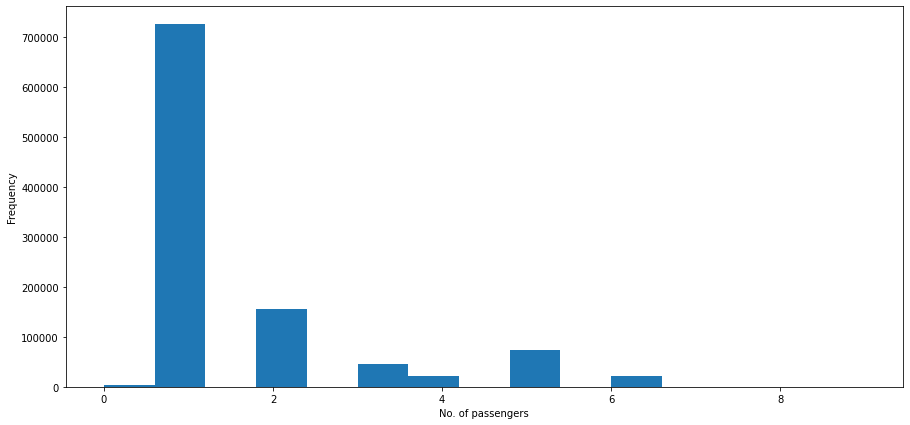

In [44]:
plt.figure(figsize = (15,7))
plt.hist(train['passenger_count'], bins = 15)
plt.xlabel('No. of passengers')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

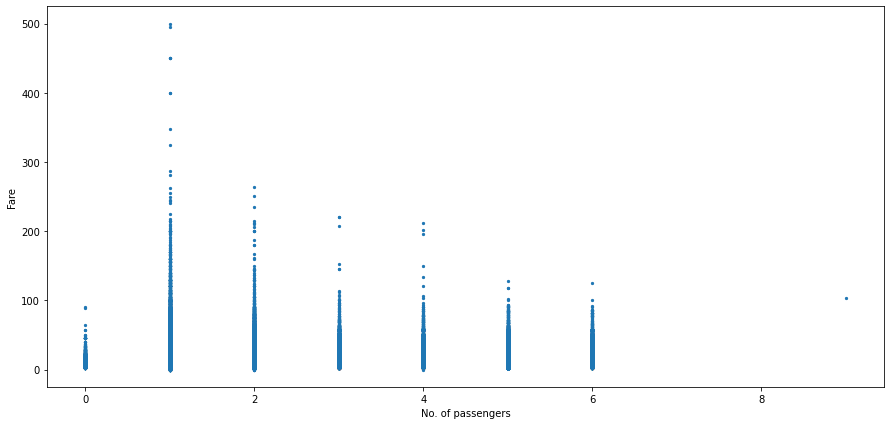

In [45]:
plt.figure(figsize = (15,7))
plt.scatter(x = train['passenger_count'], y = train['fare_amount'], s = 5)
plt.xlabel('No. of passengers')
plt.ylabel('Fare')

######  2. 승차 일/시간 - 요금 사이 관계 여부

In [46]:
# pickup_datetime > year, month, date, hour, day of week 파생변수 생성

# train, test 모두 적용해주기 위해, data라는 list로 묶어서 한 번에 수정해줌
data = [train, test]

for df in data :
    df['year'] = df['pickup_datetime'].dt.year 
    df['month'] = df['pickup_datetime'].dt.month 
    df['date'] = df['pickup_datetime'].dt.day 
    df['hour'] = df['pickup_datetime'].dt.hour 
    df['dayofweek'] = df['pickup_datetime'].dt.dayofweek 


In [47]:
display(train.head(3))
display(test.head(3))

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek
0,26:21.0,4.50000,2009-06-15 17:26:21+00:00,-73.84431,40.72132,-73.84161,40.71228,1.00000,2009,6,15,17,0
1,52:16.0,16.90000,2010-01-05 16:52:16+00:00,-74.01605,40.71130,-73.97927,40.78200,1.00000,2010,1,5,16,1
2,35:00.0,5.70000,2011-08-18 00:35:00+00:00,-73.98274,40.76127,-73.99124,40.75056,2.00000,2011,8,18,0,3


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek
0,2015-01-27 13:08:24.000000200,2015-01-27 13:08:24+00:00,-73.97332,40.76381,-73.98143,40.74384,1,2015,1,27,13,1
1,2015-01-27 13:08:24.000000300,2015-01-27 13:08:24+00:00,-73.98686,40.71938,-73.99889,40.73920,1,2015,1,27,13,1
2,2011-10-08 11:53:44.000000200,2011-10-08 11:53:44+00:00,-73.98252,40.75126,-73.97965,40.74614,1,2011,10,8,11,5


아래 시각화를 통해 다음과 같은 사실을 확인할 수 있음<br>
1. Month/Date : 택시 승하차 빈도 및 요금은 대체로 균일함. 
2. Hour : 새벽5시에 승하차 빈도가 가장 낮음 / 오후 8시 가량에 가장 승하차 많이 발생<br>
큰 차이는 아니지만 요금 역시, 시간에 따라 높고 낮음의 차이가 발생<br>
    -> important feature로 작용 예상


Text(0, 0.5, 'Fare')

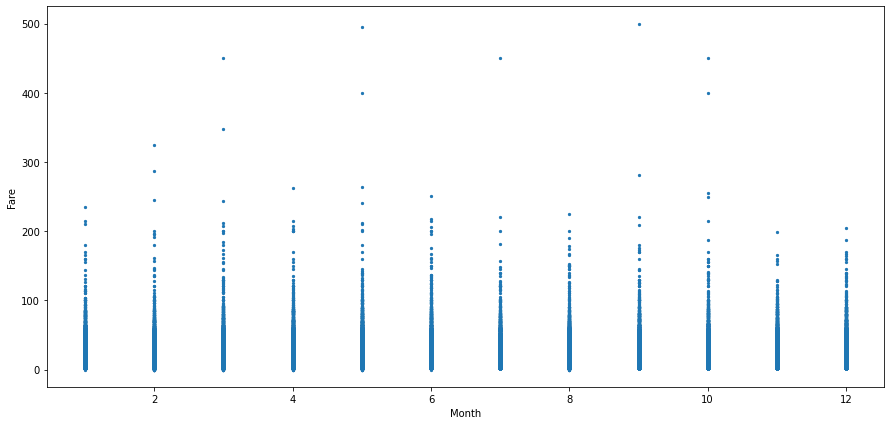

In [48]:
# 시각화
plt.figure(figsize=(15,7))
plt.scatter(x=train['month'], y=train['fare_amount'], s=5)
plt.xlabel('Month')
plt.ylabel('Fare')

Text(0, 0.5, 'Frequency')

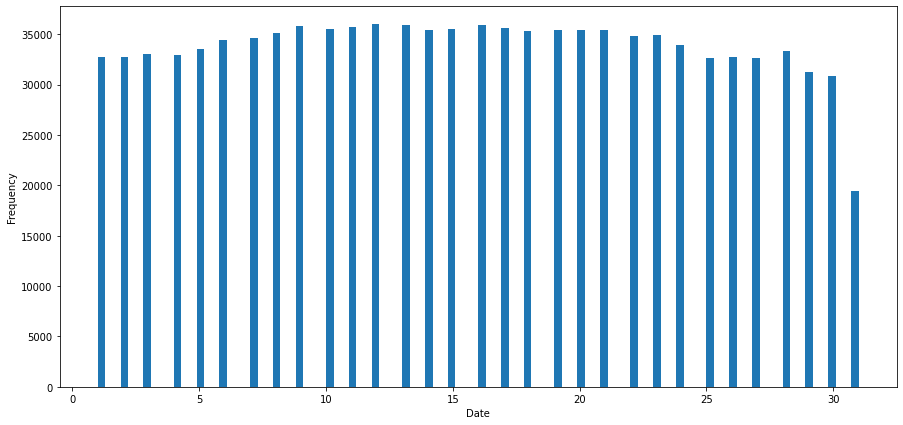

In [49]:
plt.figure(figsize=(15,7))
plt.hist(train['date'], bins=100)
plt.xlabel('Date')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

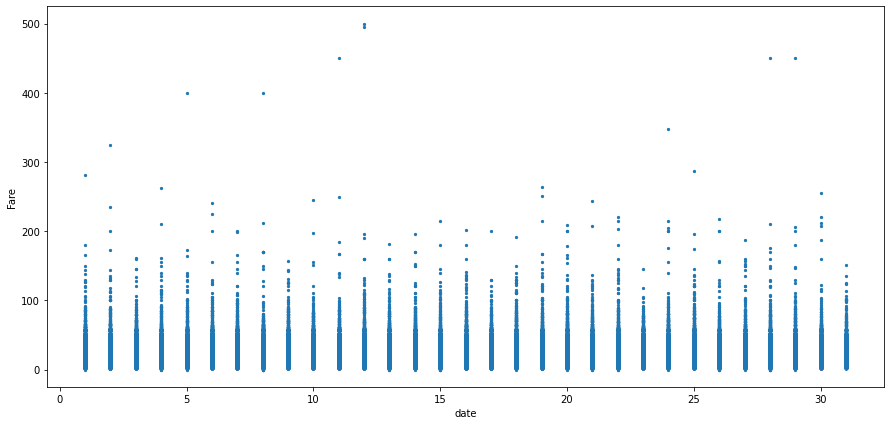

In [50]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['date'], y=train['fare_amount'], s=5)
plt.xlabel('date')
plt.ylabel('Fare')

Text(0, 0.5, 'Frequency')

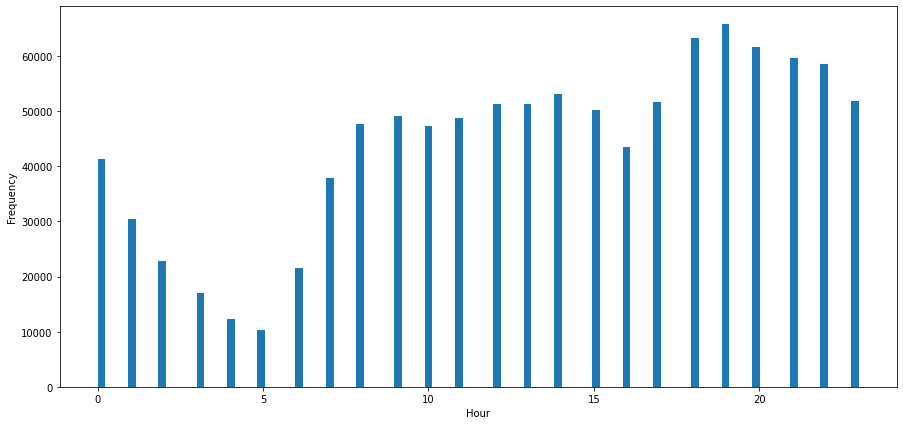

In [51]:
plt.figure(figsize=(15,7))
plt.hist(train['hour'], bins=100)
plt.xlabel('Hour')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

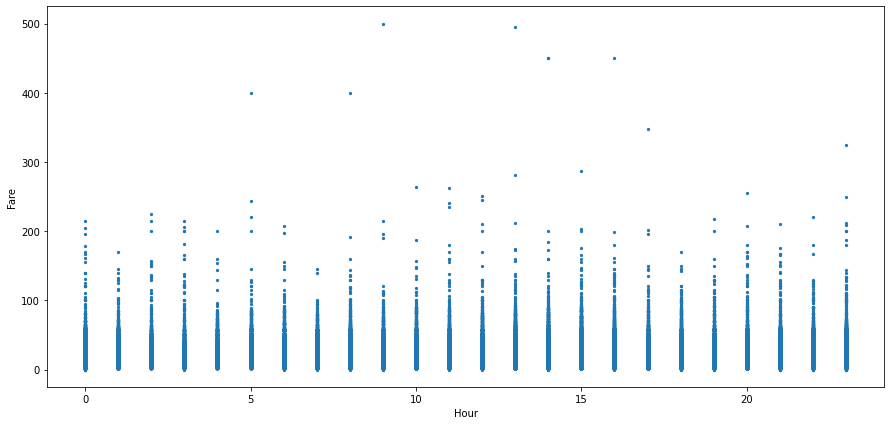

In [52]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['hour'], y=train['fare_amount'], s=5)
plt.xlabel('Hour')
plt.ylabel('Fare')

###### 3. 요일 - 요금 사이 관계 여부
의외로 요일에 따른 승하차 빈도나 요금 차이는 크게 없어보임.

Text(0, 0.5, 'Frequency')

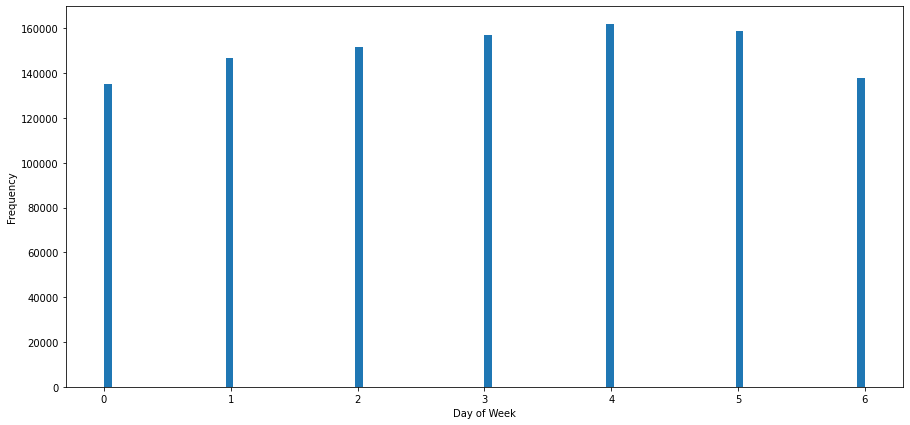

In [53]:
plt.figure(figsize=(15,7))
plt.hist(train['dayofweek'], bins=100)
plt.xlabel('Day of Week')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

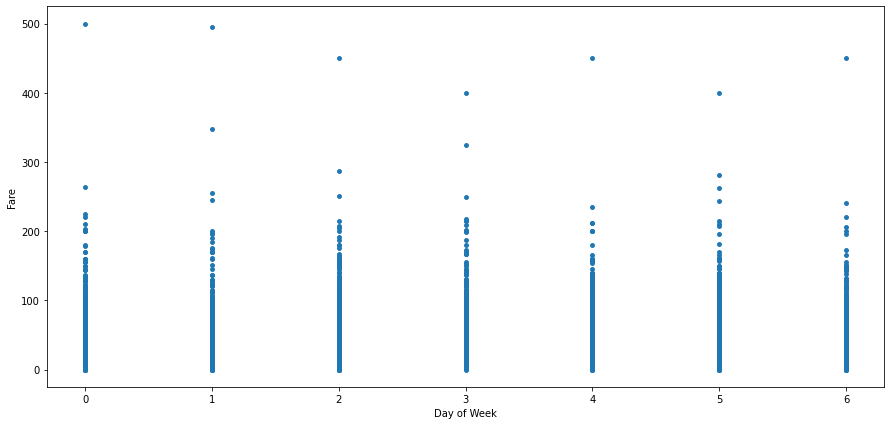

In [54]:
plt.figure(figsize=(15,7))
plt.scatter(x=train['dayofweek'], y=train['fare_amount'], s=15)
plt.xlabel('Day of Week')
plt.ylabel('Fare')

###### 4. 주행거리 - 요금 사이 관계 여부
주행거리는 Haversine formula에 의거해서 구해줌<br>
Harversine formula : 지구를 구(sphere)로 가정, 두 지점의 좌표(경도, 위도)를 이용하여 지구 표면 상의 대원 거리(great-circle distance)를 계산<br>

```
haversine(θ) = sin²(θ/2)
φ = latitude / λ = longitude, R = earth’s radius (mean radius = 6,371km) 
A, B : pickup / dropoff location 좌표
    1. a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    2. c = 2 * atan2( √a, √(1−a) )
    3. d = R ⋅ c
    4. d = Haversine distance
```

In [55]:
# 위 공식에 의해(1~4), 승차지 - 하차지 사이 Harversine distance 구하는 함수 정의해줌
def harversine_distance(lat1, long1, lat2, long2): # 아래에서 정의한 내용에 따라, lat1/long1/lat2/long2는 train, test 데이터의 column 명이라는 걸 알 수 있다!
    data = [train, test]
    for df in data :
        R = 6371 # 지구 반지름 (단위 : km)
        phi1 = np.radians(df[lat1]) # π rad = 180도
        phi2 = np.radians(df[lat2])

        delta_phi = np.radians(df[lat2]-df[lat1])
        delta_lambda = np.radians(df[long2]-df[long1])

        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin( delta_phi/2 )**2 + np.cos(phi1) * np.cos(phi2) * (np.sin(delta_lambda/2) ** 2)
        # c
        c = 2 * np.arctan2( np.sqrt(a), np.sqrt(1-a) )
        # d
        d = R * c # 단위 : km
        df['haver_distance'] = d
    return d

In [56]:
# pickup - dropoff location 사이 거리 구하기 위해, distance 컬럼 만들어줌
harversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0       2.32326
1       2.42535
2       0.61863
3       1.96103
4       5.38730
         ...   
9909    2.12487
9910    3.27097
9911   19.18394
9912    8.34349
9913    1.18083
Length: 9914, dtype: float64

In [57]:
train['haver_distance'].head(10)

0   1.03076
1   8.45013
2   1.38953
3   2.79927
4   1.99916
5   3.78724
6   1.55581
7   4.15544
8   1.25323
9   2.84963
Name: haver_distance, dtype: float64

In [58]:
test.haver_distance.head(10)

0    2.32326
1    2.42535
2    0.61863
3    1.96103
4    5.38730
5    3.22255
6    0.92960
7   21.54010
8    3.87396
9    1.09979
Name: haver_distance, dtype: float64

시각화를 통해 거리와 요금 사이 관계를 표현해봄

In [59]:
train.sort_values(by = ['haver_distance', 'fare_amount'], ascending = False)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance
228825,19:37.0,32.10000,2012-06-03 11:19:37+00:00,-73.86336,40.76928,45.58162,-2.01346,2.00000,2012,6,3,11,6,12594.70472
81035,24:00.0,10.50000,2012-02-08 20:24:00+00:00,-89.43979,1.70796,0.00000,0.00000,1.00000,2012,2,8,20,2,9945.27801
258846,40:00.0,4.90000,2010-11-14 21:40:00+00:00,0.00000,0.00000,-73.96030,81.51018,1.00000,2010,11,14,21,6,9747.58743
401445,28:03.0,14.50000,2011-02-26 03:28:03+00:00,0.00000,0.00000,-75.43337,40.75205,1.00000,2011,2,26,3,5,8786.23563
207647,56:04.0,38.90000,2011-04-19 17:56:04+00:00,0.00000,0.00000,-75.42375,40.77388,1.00000,2011,4,19,17,1,8785.84324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265519,29:21.0,0.01000,2015-01-21 06:29:21+00:00,0.00000,0.00000,0.00000,0.00000,1.00000,2015,1,21,6,2,0.00000
105051,41:00.0,0.00000,2013-08-21 21:41:00+00:00,0.00000,0.00000,0.00000,0.00000,2.00000,2013,8,21,21,2,0.00000
331597,45:54.0,0.00000,2013-08-05 06:45:54+00:00,-73.98235,40.67997,-73.98235,40.67997,1.00000,2013,8,5,6,0,0.00000
436658,33:39.0,0.00000,2015-03-04 22:33:39+00:00,-74.04344,40.78821,-74.04344,40.78821,1.00000,2015,3,4,22,2,0.00000


In [60]:
train.haver_distance.min(), train.haver_distance.max()

(0.0, 12594.704724842262)

In [61]:
# 10km 간격으로 bins 나누어 시각화해줌
bins0 = train.loc[ (train['haver_distance'] == 0), ['haver_distance'] ]
bins1 = train.loc[ (train['haver_distance'] > 0) & (train['haver_distance'] <= 10), ['haver_distance'] ]
bins2 = train.loc[ (train['haver_distance'] > 10) & (train['haver_distance'] <= 50), ['haver_distance'] ]
bins3 = train.loc[ (train['haver_distance'] > 50) & (train['haver_distance'] <= 100), ['haver_distance'] ]
bins4 = train.loc[ (train['haver_distance'] > 100) & (train['haver_distance'] <= 200), ['haver_distance'] ]
bins5 = train.loc[ (train['haver_distance'] > 200) & (train['haver_distance'] <= 300), ['haver_distance'] ]
bins6 = train.loc[ (train['haver_distance'] > 300) , ['haver_distance'] ]

bins0['bins'] = '0'
bins1['bins'] = '0-10'
bins2['bins'] = '10-50'
bins3['bins'] = '50-100'
bins4['bins'] = '100-200'
bins5['bins'] = '200-300'
bins6['bins'] = '>300'

dist_bins = pd.concat([bins0, bins1, bins2, bins3, bins4, bins5, bins6])

print(len(dist_bins), len(train))
print(dist_bins.columns)

1048396 1048396
Index(['haver_distance', 'bins'], dtype='object')


Text(0, 0.5, 'Frequency')

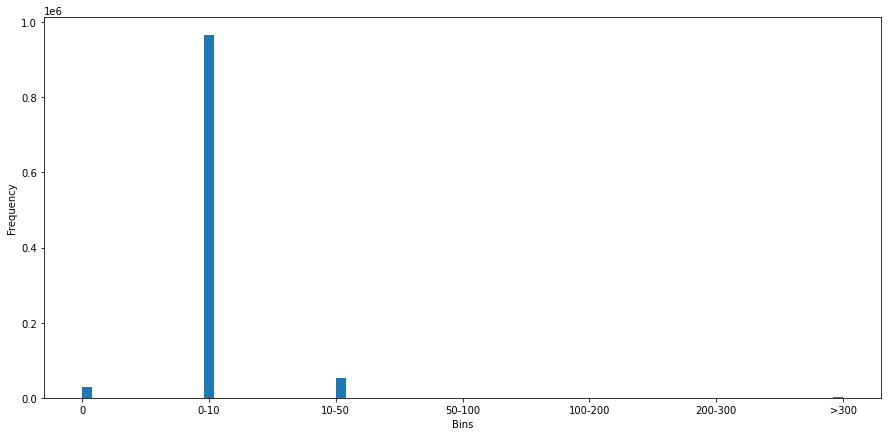

In [62]:
plt.figure(figsize=(15,7))
plt.hist(dist_bins['bins'], bins=75)
plt.xlabel('Bins')
plt.ylabel('Frequency')

In [63]:
Counter(dist_bins['bins'])


Counter({'0': 29829,
         '0-10': 964715,
         '10-50': 51450,
         '100-200': 214,
         '200-300': 6,
         '50-100': 160,
         '>300': 2022})

In [64]:
# dist_bins.bins.value_counts()
# 얘랑은 Series vs dictionary랑 유사한 형태의 Counter object로 리턴되는 형태가 다름

#### 위도/경도 - 요금 관련, 이상값 보정
1. 승차 or 하차가 존재하지만, 요금은 0
    - Pickup latitude / pickup longitude == 0 but dropoff latitude / longitude != 0 (fare == 0) > 요금 데이터 기준, 샘플 삭제
    - Pickup latitude / pickup longitude != 0 but dropoff latitude / longitude == 0 (fare == 0) > 요금 데이터 기준, 샘플 삭제
2. 승차 or 하차가 없는데, 요금은 존재
    - Pickup latitude / pickup longitude == 0 but dropoff latitude / longitude != 0 (and fare != 0) > 이 경우엔 distance 데이터 보정해줌
    - 비슷한 상황으로 거리가 0인데 다른 데이터가 존재하는 경우도 확인해줌

##### 1. 승차 or 하차가 존재하지만, 요금은 0

In [65]:
train = train.drop(train.loc[ (train['pickup_latitude']==0) & (train['pickup_longitude']==0) &
                             (train['dropoff_latitude']!=0) & (train['dropoff_longitude']!=0) &
                             (train['fare_amount']==0) ].index, axis=0)

In [66]:
train = train.drop(train.loc[ (train['pickup_latitude']!=0) & (train['pickup_longitude']!=0) &
                             (train['dropoff_latitude']==0) & (train['dropoff_longitude']==0) &
                             (train['fare_amount']==0) ].index, axis=0)

In [67]:
train.shape

(1048388, 14)

In [68]:
# test data - 해당 데이터 없음!
test.loc[ (test['pickup_latitude']==0) & (test['pickup_longitude']==0) &
           (test['dropoff_latitude']!=0) & (test['dropoff_longitude']!=0) ]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance


In [69]:
test.loc[ (test['pickup_latitude']!=0) & (test['pickup_longitude']!=0) &
           (test['dropoff_latitude']==0) & (test['dropoff_longitude']==0) ]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance


##### 2. 승차 or 하차가 없는데, 요금은 존재

여기서 도메인 지식 관련, 뉴욕 시내에서 택시로 주행 가능한 최대 거리는 200km임! <br>
따라서 haver_distance가 200km 이상인 샘플을 확인


In [70]:
high_distance = train.loc[ (train['haver_distance']>200) & (train['fare_amount']!=0) ]
print(high_distance.shape)
display(high_distance.head())

(2024, 14)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance
472,48:00.0,2.50000,2009-02-22 22:48:00+00:00,0.00000,0.00000,-74.00543,40.72669,2.00000,2009,2,22,22,6,8667.30497
1260,25:00.0,5.70000,2011-03-10 20:25:00+00:00,-73.97391,40.75474,0.00000,0.00000,2.00000,2011,3,10,20,3,8665.26859
2280,24:00.0,8.90000,2011-08-29 08:24:00+00:00,-73.93667,40.75782,0.00000,40.75782,1.00000,2011,8,29,8,0,6026.49422
2397,11:10.0,45.00000,2012-06-24 17:11:10+00:00,0.00000,0.00000,-74.01023,40.71455,2.00000,2012,6,24,17,6,8667.45442
4278,33:02.0,7.00000,2015-04-07 23:33:02+00:00,-73.97270,40.75742,0.00000,0.00000,1.00000,2015,4,7,23,1,8665.22377


high_distance 데이터의 haver_distance를 보면, 모두 비정상적으로 높음을 알 수 있음<br>
이는 승/하차지 위/경도가 0 혹은 잘못된 값이 들어가 있기 떄문인데,<br>
만약 모든 샘플이 요금 정보를 가지고 있다면 (0보다 큰) 이는 무엇보다 중요한 데이터를 포함하고 있다는 의미이기에, <br>
데이터를 drop하기보다 아래 수식을 이용해서 distance값을 보정해주려 함<br>
```
distance = (fare_amount - 2.5)/1.56
```


In [71]:
high_distance['haver_distance'] = high_distance.apply(
    lambda row : (row['fare_amount']-2.5)/1.56, 
    axis = 1
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[참고. Series - map / DataFrame - apply / both - applymap](http://www.leejungmin.org/post/2018/04/21/pandas_apply_and_map/)

In [72]:
high_distance.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance
472,48:00.0,2.50000,2009-02-22 22:48:00+00:00,0.00000,0.00000,-74.00543,40.72669,2.00000,2009,2,22,22,6,0.00000
1260,25:00.0,5.70000,2011-03-10 20:25:00+00:00,-73.97391,40.75474,0.00000,0.00000,2.00000,2011,3,10,20,3,2.05128
2280,24:00.0,8.90000,2011-08-29 08:24:00+00:00,-73.93667,40.75782,0.00000,40.75782,1.00000,2011,8,29,8,0,4.10256
2397,11:10.0,45.00000,2012-06-24 17:11:10+00:00,0.00000,0.00000,-74.01023,40.71455,2.00000,2012,6,24,17,6,27.24359
4278,33:02.0,7.00000,2015-04-07 23:33:02+00:00,-73.97270,40.75742,0.00000,0.00000,1.00000,2015,4,7,23,1,2.88462
4597,12:00.0,6.90000,2010-03-30 07:12:00+00:00,0.00000,0.00000,-73.98969,40.75428,1.00000,2010,3,30,7,1,2.82051
5864,35:00.0,8.50000,2012-03-04 01:35:00+00:00,-73.99503,40.74495,-7.98664,40.72994,1.00000,2012,3,4,1,6,3.84615
6188,04:00.0,15.50000,2014-07-28 15:04:00+00:00,0.00000,0.00000,-73.95298,40.78667,5.00000,2014,7,28,15,0,8.33333
6302,18:58.0,16.50000,2015-02-27 16:18:58+00:00,0.00000,0.00000,-73.93660,40.79654,1.00000,2015,2,27,16,4,8.97436
7014,03:00.0,4.50000,2011-06-18 04:03:00+00:00,-73.98898,40.72170,-74.00107,0.72809,3.00000,2011,6,18,4,5,1.28205


In [73]:
temp = high_distance.index.tolist()
train.loc[temp]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance
472,48:00.0,2.50000,2009-02-22 22:48:00+00:00,0.00000,0.00000,-74.00543,40.72669,2.00000,2009,2,22,22,6,8667.30497
472,06:00.0,6.10000,2012-01-14 16:06:00+00:00,-73.98319,40.77649,-73.97204,40.79705,1.00000,2012,1,14,16,5,2.47165
1260,25:00.0,5.70000,2011-03-10 20:25:00+00:00,-73.97391,40.75474,0.00000,0.00000,2.00000,2011,3,10,20,3,8665.26859
1260,06:42.0,5.00000,2015-01-28 17:06:42+00:00,-73.99646,40.75323,-74.00541,40.74007,2.00000,2015,1,28,17,2,1.64694
2280,24:00.0,8.90000,2011-08-29 08:24:00+00:00,-73.93667,40.75782,0.00000,40.75782,1.00000,2011,8,29,8,0,6026.49422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481103,28:50.0,9.50000,2013-08-27 20:28:50+00:00,-74.00688,40.72015,0.00000,0.00000,1.00000,2013,8,27,20,1,8667.29107
481325,26:53.0,6.00000,2013-06-27 19:26:53+00:00,-73.98366,40.74855,-73.96966,40.75303,1.00000,2013,6,27,19,3,1.27995
481325,37:14.0,27.33000,2014-08-22 00:37:14+00:00,0.00000,0.00000,-73.89049,40.70189,1.00000,2014,8,22,0,4,8657.27502
482743,57:00.0,12.50000,2012-12-16 10:57:00+00:00,-74.00813,40.70473,-73.98811,40.73461,5.00000,2012,12,16,10,6,3.72612


In [74]:
#sync the train data with the newly computed distance values from high_distance dataframe
# train.update(high_distance, overwrite = True, errors = 'ignore')

In [75]:
for index in temp : 
    train.loc[index, 'haver_distance'] = high_distance.loc[index, 'haver_distance']

train.loc[temp]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance
472,48:00.0,2.50000,2009-02-22 22:48:00+00:00,0.00000,0.00000,-74.00543,40.72669,2.00000,2009,2,22,22,6,0.00000
472,06:00.0,6.10000,2012-01-14 16:06:00+00:00,-73.98319,40.77649,-73.97204,40.79705,1.00000,2012,1,14,16,5,0.00000
1260,25:00.0,5.70000,2011-03-10 20:25:00+00:00,-73.97391,40.75474,0.00000,0.00000,2.00000,2011,3,10,20,3,2.05128
1260,06:42.0,5.00000,2015-01-28 17:06:42+00:00,-73.99646,40.75323,-74.00541,40.74007,2.00000,2015,1,28,17,2,2.05128
2280,24:00.0,8.90000,2011-08-29 08:24:00+00:00,-73.93667,40.75782,0.00000,40.75782,1.00000,2011,8,29,8,0,4.10256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481103,28:50.0,9.50000,2013-08-27 20:28:50+00:00,-74.00688,40.72015,0.00000,0.00000,1.00000,2013,8,27,20,1,4.48718
481325,26:53.0,6.00000,2013-06-27 19:26:53+00:00,-73.98366,40.74855,-73.96966,40.75303,1.00000,2013,6,27,19,3,15.91667
481325,37:14.0,27.33000,2014-08-22 00:37:14+00:00,0.00000,0.00000,-73.89049,40.70189,1.00000,2014,8,22,0,4,15.91667
482743,57:00.0,12.50000,2012-12-16 10:57:00+00:00,-74.00813,40.70473,-73.98811,40.73461,5.00000,2012,12,16,10,6,0.96154


The update() method updates a DataFrame with elements from another similar object (like another DataFrame).


* 에러 기록* 위 컬럼에서 train에 새롭게 계산한 high_distance 값을 업데이트 하는 과정에서 ValueError가 남<br>
- ValueError: cannot reindex from a duplicate axis<br>
구글링해보니, 행이 아니라, 기존 데이터프레임과 업데이트 해주려는 데이터 프레임의 컬럼명이 같아서 생기는 에러라 함. <br>

그치만 문제는 노트북에서 한 건 구글링해서 찾은 방법을 동원해봐도 작동하지 않아서, 일단 index 기준으로 수작업으로 업데이트 해주기로 함! <br>


In [76]:
train.shape

(1048388, 14)

In [77]:
# 거리가 0인 샘플 확인
train[train['haver_distance']==0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance
11,24:00.0,5.50000,2012-12-24 11:24:00+00:00,0.00000,0.00000,0.00000,0.00000,3.00000,2012,12,24,11,0,0.00000
15,57:00.0,5.00000,2013-11-23 12:57:00+00:00,0.00000,0.00000,0.00000,0.00000,1.00000,2013,11,23,12,5,0.00000
26,01:00.0,6.50000,2011-02-07 20:01:00+00:00,0.00000,0.00000,0.00000,0.00000,1.00000,2011,2,7,20,0,0.00000
105,08:52.0,52.00000,2009-03-25 00:08:52+00:00,-74.03584,40.74732,-74.03584,40.74732,1.00000,2009,3,25,0,2,0.00000
124,22:00.0,8.00000,2013-01-17 17:22:00+00:00,0.00000,0.00000,0.00000,0.00000,2.00000,2013,1,17,17,3,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483021,14:18.0,10.90000,2009-03-21 16:14:18+00:00,0.00000,0.00000,0.00000,0.00000,2.00000,2009,3,21,16,5,0.00000
483169,41:27.0,7.70000,2011-01-15 22:41:27+00:00,0.00000,0.00000,0.00000,0.00000,3.00000,2011,1,15,22,5,0.00000
483262,14:00.0,6.10000,2009-11-17 17:14:00+00:00,-73.97962,40.73987,-73.97962,40.73987,1.00000,2009,11,17,17,1,0.00000
483297,06:00.0,4.50000,2011-02-14 20:06:00+00:00,-73.98906,40.74160,-73.98906,40.74160,1.00000,2011,2,14,20,0,0.00000


거리가 0인 이유에는 두 가지가 있을 수 있음.<br>
1. 승차지 == 하차지 : 승객이 택시 콜을 취소하고, 대기하던 시간에 대해 요금을 지불함<br>
2. 승차/하차지 데이터가 결측됨<br>
그러나 이 데이터를 버리기엔 몇 만 건으로 샘플 수가 매우 많음. <br>
따라서 결측된 거리 데이터를, 요금과 뉴욕 시 km 당 평균 택시 요금을 기준으로 채워 줄거임.<br>

구글 기준, 요일 별 뉴욕 시 평균 택시 요금은 아래와 같음<br>
1. \$$2.5(기본요금) +\$1.56/km (6AM to 8PM Mon-Fri)

2. \$$3.0(기본요금) +\$1.56/km (8PM to 6AM Mon-Fri and Sat&Sun)

train dataset의 missing fare_amount - haver_distance 결측치에 대해,아래 네 가지 상황을 가정하여 처리해줄거임<br>
1. fare_amount == 0 and haver_distance == 0 <br>
이 경우 해당 샘플이 우리에게 제공하는 의미있는 데이터가 없으므로, 행 삭제<br>
2. fare_amount > 0 but fare_amount < 기본요금, and haver_distance == 0<br>
이 경우 해당 샘플이 우리에게 의미있는, 정확한 데이터를 제공하지 못하므로 행 삭제<br>
3. fare_amount == 0 but haver_distance > 0<br>
이 경우 위 요금 계산 공식 (fare = 2.5 + 1.56(H_Distance))에 근거해서 fare_amount 값 계산<br>
4. fare_amount > 0 but haver_distance == 0<br>
반대로 distance = (fare_amount - 2.5)/1.56에 근거해서 distance 계산



In [78]:
# 1. fare_amount == 0 and haver_distance == 0
train[ (train['fare_amount']==0) & (train['haver_distance']==0) ]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance
105051,41:00.0,0.00000,2013-08-21 21:41:00+00:00,0.00000,0.00000,0.00000,0.00000,2.00000,2013,8,21,21,2,0.00000
331597,45:54.0,0.00000,2013-08-05 06:45:54+00:00,-73.98235,40.67997,-73.98235,40.67997,1.00000,2013,8,5,6,0,0.00000
436658,33:39.0,0.00000,2015-03-04 22:33:39+00:00,-74.04344,40.78821,-74.04344,40.78821,1.00000,2015,3,4,22,2,0.00000
124153,10:03.0,0.00000,2015-05-27 23:10:03+00:00,-73.99413,40.74113,-73.99413,40.74113,1.00000,2015,5,27,23,2,0.00000


In [79]:
train = train.drop(train[ (train['fare_amount']==0) & (train['haver_distance']==0) ].index, axis = 0)
train[train.haver_distance==0].shape

(30138, 14)

In [80]:
# 2. fare_amount > 0 but fare_amount < 기본요금, and haver_distance == 0

In [81]:
# mon-fri, 6am - 8pm
rush_hour = train.loc[
            ((train['hour']>=6) & (train['hour']<=20)) &
            ((train['dayofweek']>=1) & (train['dayofweek']<=5)) &
            (train['haver_distance']==0) & 
            ((train['fare_amount']>0) & (train['fare_amount']<2.5))
            ]
rush_hour

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance
265519,29:21.0,0.01000,2015-01-21 06:29:21+00:00,0.00000,0.00000,0.00000,0.00000,1.00000,2015,1,21,6,2,0.00000
360795,12:00.0,1.90000,2015-01-21 14:12:00+00:00,0.00000,0.00000,0.00000,0.00000,1.00000,2015,1,21,14,2,0.00000


In [82]:
train = train.drop(rush_hour.index, axis = 0)
train.shape

(1048376, 14)

In [83]:
# mon-fri, 8pm - 6am
non_rush_hour = train.loc[
                    ((train['hour']<6) | (train['hour']>20)) &
                    ((train['dayofweek']>=1) & (train['dayofweek']<=5)) &
                    (train['haver_distance']==0) & 
                    ((train['fare_amount']>0) & (train['fare_amount']<3.0))
                ]
non_rush_hour

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance
376,57:22.0,2.50000,2014-05-29 05:57:22+00:00,0.00000,0.00000,0.00000,0.00000,1.00000,2014,5,29,5,3,0.00000
503,10:00.0,2.50000,2010-01-19 01:10:00+00:00,-73.99872,40.62471,-73.99872,40.62471,1.00000,2010,1,19,1,1,0.00000
657,50:21.0,2.50000,2009-08-25 01:50:21+00:00,-73.98641,40.76335,-73.98641,40.76335,1.00000,2009,8,25,1,1,0.00000
3168,07:00.0,2.50000,2012-07-06 22:07:00+00:00,0.00000,0.00000,0.00000,0.00000,1.00000,2012,7,6,22,4,0.00000
12953,30:08.0,2.90000,2010-07-23 03:30:08+00:00,0.00000,0.00000,0.00000,0.00000,1.00000,2010,7,23,3,4,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469665,08:00.0,2.50000,2011-07-02 05:08:00+00:00,-73.91111,40.76209,-73.91111,40.76209,5.00000,2011,7,2,5,5,0.00000
470356,35:00.0,2.50000,2014-10-01 21:35:00+00:00,0.00000,0.00000,0.00000,0.00000,5.00000,2014,10,1,21,2,0.00000
473049,32:00.0,2.90000,2010-04-24 05:32:00+00:00,-73.84186,40.72992,-73.84186,40.72992,1.00000,2010,4,24,5,5,0.00000
473931,26:00.0,2.90000,2012-06-07 05:26:00+00:00,-73.95963,40.76700,-73.95963,40.76700,3.00000,2012,6,7,5,3,0.00000


In [84]:
train = train.drop(non_rush_hour.index, axis = 0)
train.shape

(1047871, 14)

In [85]:
# sat, sun
weekends = train.loc[((train['dayofweek']==0) | (train['dayofweek']==6)) & 
                     (train['haver_distance']==0) & 
                     (train['fare_amount'] < 3.0)
                     ]
weekends

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance
472,48:00.0,2.50000,2009-02-22 22:48:00+00:00,0.00000,0.00000,-74.00543,40.72669,2.00000,2009,2,22,22,6,0.00000
1419,10:23.0,2.50000,2013-07-21 00:10:23+00:00,-73.95656,40.77983,-73.95656,40.77983,1.00000,2013,7,21,0,6,0.00000
1774,24:00.0,2.50000,2012-08-27 15:24:00+00:00,-73.95028,40.70128,-73.95028,40.70128,1.00000,2012,8,27,15,0,0.00000
4367,14:48.0,2.50000,2014-01-13 16:14:48+00:00,-73.94841,40.74497,-73.94841,40.74497,1.00000,2014,1,13,16,0,0.00000
4954,44:35.0,2.50000,2010-01-10 13:44:35+00:00,-73.98393,40.75494,-73.98393,40.75494,1.00000,2010,1,10,13,6,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467689,51:33.0,2.50000,2010-03-07 12:51:33+00:00,-73.97924,40.76700,-73.97924,40.76700,1.00000,2010,3,7,12,6,0.00000
472822,12:46.0,2.50000,2011-05-15 18:12:46+00:00,-74.00827,40.71524,-74.00827,40.71524,1.00000,2011,5,15,18,6,0.00000
476044,09:32.0,2.50000,2014-11-03 12:09:32+00:00,-73.98855,40.75538,-73.98855,40.75538,1.00000,2014,11,3,12,0,0.00000
478543,56:00.0,2.50000,2010-02-14 20:56:00+00:00,-73.77662,40.64516,-73.77662,40.64516,5.00000,2010,2,14,20,6,0.00000


In [86]:
train = train.drop(weekends.index, axis = 0)
train.shape

(1047103, 14)

In [87]:
# 3. fare_amount == 0 but haver_distance > 0
# imputation formula : fare_amount = 2.5 + 1.56(haver_distance)

case3 = train.loc[(train['fare_amount']==0) & (train['haver_distance']>0)]
len(case3)

21

In [88]:
case3.sort_values('haver_distance', ascending = False)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance
223369,10:53.0,0.00000,2010-02-26 22:10:53+00:00,-73.81279,40.69592,-73.99358,40.74974,1.00000,2010,2,26,22,4,16.36820
197705,47:28.0,0.00000,2015-02-04 23:47:28+00:00,-73.86453,40.77001,-74.03094,40.72714,1.00000,2015,2,4,23,2,14.80627
561786,22:00.0,0.00000,2013-08-26 00:22:00+00:00,-73.98847,40.72277,-73.92369,40.80777,1.00000,2013,8,26,0,0,10.91316
10002,26:01.0,0.00000,2010-02-15 14:26:01+00:00,-73.98712,40.73881,-74.00591,40.71396,1.00000,2010,2,15,14,0,3.18476
431819,48:21.0,0.00000,2015-01-13 00:48:21+00:00,-73.99838,40.75942,-74.03119,40.74892,1.00000,2015,1,13,0,1,2.99963
330264,39:17.0,0.00000,2010-02-08 23:39:17+00:00,-73.88042,40.74143,-73.87390,40.74230,1.00000,2010,2,8,23,0,0.55767
386734,02:38.0,0.00000,2015-05-08 07:02:38+00:00,-73.99950,40.74879,-74.00256,40.74466,1.00000,2015,5,8,7,4,0.52637
520715,14:09.0,0.00000,2015-03-28 18:14:09+00:00,-73.98769,40.76488,-73.99015,40.76158,4.00000,2015,3,28,18,5,0.42123
195565,16:52.0,0.00000,2015-05-24 03:16:52+00:00,-74.00163,40.73076,-73.99975,40.73349,1.00000,2015,5,24,3,6,0.34271
47302,13:39.0,0.00000,2010-03-18 19:13:39+00:00,-73.94235,40.80627,-73.94246,40.80613,1.00000,2010,3,18,19,3,0.01842


In [89]:
# case3['fare_amount'] = 2.5 + 1.56 * case3['haver_distance'] 얘로 계산하면 안되는 이유가 뭐임?
case3['fare_amount'] = 2.50 + (case3['haver_distance'] * 1.56)
case3['fare_amount']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


10002     7.46823
27891     2.50166
47302     2.52874
175352    2.51442
211455    2.50902
211499    2.50084
266485    2.50547
386734    3.32114
431819    7.17942
489767    2.50120
495273    2.50066
520715    3.15711
561786   19.52453
105157    2.50066
116245    2.50158
195565    3.03463
197705   25.59779
223369   28.03439
330264    3.36996
372923    2.50120
392493    2.50551
Name: fare_amount, dtype: float64

In [90]:
temp = case3.index.tolist()
temp[:3]

[10002, 27891, 47302]

In [91]:
for index in temp :
    train.loc[index, 'fare_amount'] = case3.loc[index, 'fare_amount']
train.loc[temp].head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance
10002,26:01.0,7.46823,2010-02-15 14:26:01+00:00,-73.98712,40.73881,-74.00591,40.71396,1.00000,2010,2,15,14,0,3.18476
10002,28:00.0,7.46823,2014-08-03 15:28:00+00:00,-73.99347,40.75550,-73.78381,40.64365,1.00000,2014,8,3,15,6,21.61173
27891,40:28.0,2.50166,2015-05-15 21:40:28+00:00,-74.07793,40.80571,-74.07792,40.80572,1.00000,2015,5,15,21,4,0.00106


In [92]:
# 4. fare_amount > 0 but haver_distance == 0
train.loc[ (train['fare_amount']!=0) & (train['haver_distance']==0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance
11,24:00.0,5.50000,2012-12-24 11:24:00+00:00,0.00000,0.00000,0.00000,0.00000,3.00000,2012,12,24,11,0,0.00000
15,57:00.0,5.00000,2013-11-23 12:57:00+00:00,0.00000,0.00000,0.00000,0.00000,1.00000,2013,11,23,12,5,0.00000
26,01:00.0,6.50000,2011-02-07 20:01:00+00:00,0.00000,0.00000,0.00000,0.00000,1.00000,2011,2,7,20,0,0.00000
105,08:52.0,52.00000,2009-03-25 00:08:52+00:00,-74.03584,40.74732,-74.03584,40.74732,1.00000,2009,3,25,0,2,0.00000
124,22:00.0,8.00000,2013-01-17 17:22:00+00:00,0.00000,0.00000,0.00000,0.00000,2.00000,2013,1,17,17,3,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483021,14:18.0,10.90000,2009-03-21 16:14:18+00:00,0.00000,0.00000,0.00000,0.00000,2.00000,2009,3,21,16,5,0.00000
483169,41:27.0,7.70000,2011-01-15 22:41:27+00:00,0.00000,0.00000,0.00000,0.00000,3.00000,2011,1,15,22,5,0.00000
483262,14:00.0,6.10000,2009-11-17 17:14:00+00:00,-73.97962,40.73987,-73.97962,40.73987,1.00000,2009,11,17,17,1,0.00000
483297,06:00.0,4.50000,2011-02-14 20:06:00+00:00,-73.98906,40.74160,-73.98906,40.74160,1.00000,2011,2,14,20,0,0.00000


In [93]:
case4 = train.loc[ (train['fare_amount']!=0) & (train['haver_distance']==0)]
len(case4)

29375

In [94]:
case4.loc[ (case4['fare_amount']>3.0) & (case4['haver_distance']==0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,date,hour,dayofweek,haver_distance
11,24:00.0,5.50000,2012-12-24 11:24:00+00:00,0.00000,0.00000,0.00000,0.00000,3.00000,2012,12,24,11,0,0.00000
15,57:00.0,5.00000,2013-11-23 12:57:00+00:00,0.00000,0.00000,0.00000,0.00000,1.00000,2013,11,23,12,5,0.00000
26,01:00.0,6.50000,2011-02-07 20:01:00+00:00,0.00000,0.00000,0.00000,0.00000,1.00000,2011,2,7,20,0,0.00000
105,08:52.0,52.00000,2009-03-25 00:08:52+00:00,-74.03584,40.74732,-74.03584,40.74732,1.00000,2009,3,25,0,2,0.00000
124,22:00.0,8.00000,2013-01-17 17:22:00+00:00,0.00000,0.00000,0.00000,0.00000,2.00000,2013,1,17,17,3,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483021,14:18.0,10.90000,2009-03-21 16:14:18+00:00,0.00000,0.00000,0.00000,0.00000,2.00000,2009,3,21,16,5,0.00000
483169,41:27.0,7.70000,2011-01-15 22:41:27+00:00,0.00000,0.00000,0.00000,0.00000,3.00000,2011,1,15,22,5,0.00000
483262,14:00.0,6.10000,2009-11-17 17:14:00+00:00,-73.97962,40.73987,-73.97962,40.73987,1.00000,2009,11,17,17,1,0.00000
483297,06:00.0,4.50000,2011-02-14 20:06:00+00:00,-73.98906,40.74160,-73.98906,40.74160,1.00000,2011,2,14,20,0,0.00000


In [95]:
# distance = (fare_amount - 2.5)/1.56 채워주기 위해 sub_case4 만들어줌
sub_case4 = case4.loc[ (case4['fare_amount']>3.0) & (case4['haver_distance']==0)]
len(sub_case4)

28448

In [96]:
sub_case4['haver_distance'] = (sub_case4['fare_amount']-2.5)/1.56

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [97]:
temp = sub_case4.index.tolist()

for index in temp : 
    train.loc[index, 'haver_distance'] = sub_case4.loc[index, 'haver_distance']

train.shape

(1047103, 14)

# Modeling and Prediction

In [98]:
train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'year', 'month', 'date', 'hour', 'dayofweek',
       'haver_distance'],
      dtype='object')

In [99]:
test.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'date', 'hour', 'dayofweek', 'haver_distance'],
      dtype='object')

In [100]:
train = train.drop(['key','pickup_datetime'], axis = 1)
test = test.drop(['key','pickup_datetime'], axis = 1)

In [101]:
train.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'date', 'hour', 'dayofweek', 'haver_distance'],
      dtype='object')

In [102]:
test.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'year', 'month', 'date', 'hour',
       'dayofweek', 'haver_distance'],
      dtype='object')

In [103]:
x_train = train.iloc[:,train.columns!='fare_amount']
x_train
y_train = train['fare_amount'].values
x_test = test

In [104]:
x_train.shape, y_train.shape

((1047103, 11), (1047103,))

In [105]:
x_train.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'year', 'month', 'date', 'hour',
       'dayofweek', 'haver_distance'],
      dtype='object')

In [106]:
x_test.shape

(9914, 11)

In [107]:
x_test.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'year', 'month', 'date', 'hour',
       'dayofweek', 'haver_distance'],
      dtype='object')

#### RandomForestRegressor

In [108]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(x_train, y_train)
rf_predict = rf.predict(x_test)
rf_predict[:5]

array([ 9.48 , 10.8  ,  4.315,  8.884, 16.106])

In [109]:
submission = pd.read_csv('/content/drive/MyDrive/2. Kaggle Struggle/WK27_뉴욕택시가격예측_신용카드사기적발/new-york-city-taxi-fare-prediction/sample_submission.csv')
submission['fare_amount'] = rf_predict
submission.to_csv('NYC_Taxi_fare_prediction_submission_1.csv', index=False)
submission.head(20)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.48000
1,2015-01-27 13:08:24.0000003,10.80000
2,2011-10-08 11:53:44.0000002,4.31500
3,2012-12-01 21:12:12.0000002,8.88400
4,2012-12-01 21:12:12.0000003,16.10600
5,2012-12-01 21:12:12.0000005,11.06000
6,2011-10-06 12:10:20.0000001,5.27600
7,2011-10-06 12:10:20.0000003,49.22170
8,2011-10-06 12:10:20.0000002,14.13900
9,2014-02-18 15:22:20.0000002,6.03500


#### BOOSTING USING LGBM

In [110]:
import lightgbm as lgbm


In [111]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': -1,
        'verbose': 0,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'subsample_freq': 1,
        'colsample_bytree': 0.6,
        'reg_aplha': 1,
        'reg_lambda': 0.001,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1     
    }

In [112]:
import numpy as np

In [113]:
pred_test_y = np.zeros(x_test.shape[0])
pred_test_y.shape

(9914,)

In [114]:
train_set = lgbm.Dataset(x_train, y_train, silent=True) # lgbm.Dataset() : dataset으로 변환
train_set

In [115]:
model = lgbm.train(params, train_set = train_set, num_boost_round=300) # 파이썬랩

In [116]:
print(model)

In [117]:
pred_test_y = model.predict(x_test, num_iteration = model.best_iteration)
print(pred_test_y)

[10.85554088 10.55757273  4.6325008  ... 53.49802462 20.61052548
  6.77721025]


In [118]:
submission['fare_amount'] = pred_test_y
submission.to_csv('submission_LGB.csv', index=False)
submission.head(20)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.85554
1,2015-01-27 13:08:24.0000003,10.55757
2,2011-10-08 11:53:44.0000002,4.63250
3,2012-12-01 21:12:12.0000002,8.45552
4,2012-12-01 21:12:12.0000003,14.82257
5,2012-12-01 21:12:12.0000005,11.02197
6,2011-10-06 12:10:20.0000001,5.30074
7,2011-10-06 12:10:20.0000003,48.33246
8,2011-10-06 12:10:20.0000002,11.92841
9,2014-02-18 15:22:20.0000002,6.75517


##### BOOSTING USING XGBM

In [119]:
import xgboost as xgb 

In [120]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

파이썬 래퍼와 사이컷런 래퍼의 차이에 의해, 학습용과 테스트용 데이터 세트를 위해서 별도의 DMatrix를 생성해야 함<br> 

DMatrix (XGBoost 전용 데이터 세트) 
    - 입력 파라미터 : 넘파이 (data, label)


In [121]:
dtrain

In [122]:
params = {'max_depth':7,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.05
         }
num_rounds = 50

In [123]:
xb = xgb.train(params, dtrain, num_rounds)

In [124]:
y_pred_xgb = xb.predict(dtest)
print(y_pred_xgb)

[ 9.574913  9.711151  4.80796  ... 49.820206 19.988699  6.26808 ]


In [125]:
submission['fare_amount'] = y_pred_xgb
submission.to_csv('submission_XGB.csv', index=False)
submission.head(20)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.57491
1,2015-01-27 13:08:24.0000003,9.71115
2,2011-10-08 11:53:44.0000002,4.80796
3,2012-12-01 21:12:12.0000002,7.38989
4,2012-12-01 21:12:12.0000003,13.89852
5,2012-12-01 21:12:12.0000005,10.35440
6,2011-10-06 12:10:20.0000001,4.90606
7,2011-10-06 12:10:20.0000003,44.23988
8,2011-10-06 12:10:20.0000002,10.70983
9,2014-02-18 15:22:20.0000002,5.53141


결론

향후 추가로 해 볼 필사작업
[Kaggle 뉴욕 택시 가격 예측 - 노트북2](https://www.kaggle.com/code/breemen/nyc-taxi-fare-data-exploration)